# Data Analysis

In [100]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import seaborn as sns
from tensorflow import keras

In [101]:
df = pd.read_hdf('data/cicy3o.h5')

In [102]:
df.describe()

,euler,h11,h21,num_cp,num_eqs,min_dim_cp,max_dim_cp,mean_dim_cp,median_dim_cp,num_cp_1,...,num_over,num_ex,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,rank_matrix,norm_matrix,isprod,favour
count,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,...,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.0
mean,-42.649937,7.419772,28.744740,6.540684,7.301648,1.020152,2.708999,1.616977,1.409252,3.572750,...,3.760963,2.239037,2.027503,3.277186,2.378916,2.172687,6.216857,4.242878,0.002788,0.0
std,20.589891,2.250891,8.577282,1.596812,2.087152,0.184930,0.791630,0.296287,0.482226,1.442995,...,1.163259,1.163259,0.212140,0.651334,0.334796,0.407180,1.723061,0.333623,0.052734,0.0
min,-200.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,0.000000,0.0
25%,-52.000000,6.000000,23.000000,5.000000,6.000000,1.000000,2.000000,1.428571,1.000000,3.000000,...,3.000000,1.000000,2.000000,3.000000,2.166667,2.000000,5.000000,4.000000,0.000000,0.0
50%,-40.000000,7.000000,27.000000,7.000000,7.000000,1.000000,3.000000,1.571429,1.000000,4.000000,...,4.000000,2.000000,2.000000,3.000000,2.285714,2.000000,6.000000,4.242641,0.000000,0.0
75%,-28.000000,9.000000,33.000000,8.000000,9.000000,1.000000,3.000000,1.714286,2.000000,5.000000,...,5.000000,3.000000,2.000000,4.000000,2.500000,2.000000,7.000000,4.472136,0.000000,0.0
max,0.000000,19.000000,101.000000,12.000000,15.000000,7.000000,7.000000,7.000000,7.000000,9.000000,...,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,12.000000,5.477226,1.000000,0.0


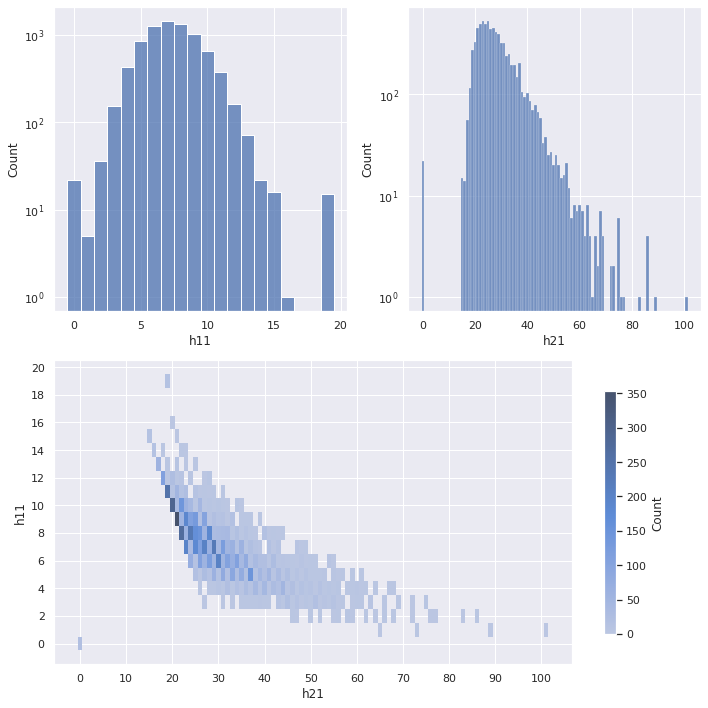

In [103]:
sns.set()
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
ax3.yaxis.set_ticks(range(0,21,2))
ax3.xaxis.set_ticks(range(0,110,10))
sns.histplot(data = df, x = 'h11', ax = ax1, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', ax = ax2, log_scale = (False,True), discrete = True)
sns.histplot(data = df, x = 'h21', y = 'h11', cbar = True, cbar_kws = {'label':'Count','shrink':.80}, ax = ax3, discrete = True)
fig.tight_layout()

<AxesSubplot:>

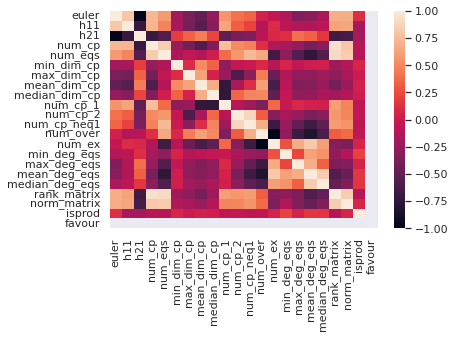

In [104]:
sns.heatmap(df.corr(), xticklabels = 1, yticklabels = 1)

In [105]:
rf = skl.ensemble.RandomForestRegressor()
fNames = ['num_cp', 'num_eqs', 'min_dim_cp', 'max_dim_cp', 'mean_dim_cp', 'median_dim_cp', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'min_deg_eqs', 'max_deg_eqs', 'mean_deg_eqs', 'median_deg_eqs', 'rank_matrix', 'norm_matrix']
xTrain = df[fNames]
yTrain1 = df['h11']
yTrain2 = df['h21']
fImportance = pd.DataFrame()
fImportance['feature'] = fNames
rf.fit(xTrain,yTrain1)
fImportance['h11'] = rf.feature_importances_
rf.fit(xTrain,yTrain2)
fImportance['h21'] = rf.feature_importances_

KeyboardInterrupt: 

In [ ]:
fImportance = pd.melt(fImportance.sort_values(by = 'h11', ascending=False), id_vars = 'feature', var_name = 'number', value_name = 'importance')

<AxesSubplot:xlabel='importance', ylabel='feature'>

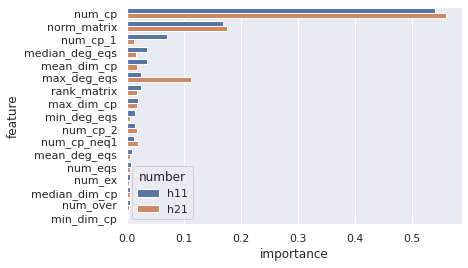

In [ ]:
sns.barplot(data=fImportance, y = 'feature', x = 'importance', ci = None, hue = 'number')

# Neural Network

## Preprocessing

In [ ]:
def filter_outliers(data,bounds):
    df = data.copy(deep=True)
    for i in bounds:
        df = df.loc[(df[i]>=bounds[i][0]) & (data[i]<= bounds[i][1])]
    return df

def pad_and_stack(data,size):
    ar = np.ndarray(shape=(len(data),*size))
    for j in range(len(data.values)):
        x = np.array(data.values[j])
        ar[j,:,:] = np.pad(x, [(0,size[i]-x.shape[i]) for i in range(len(size))])
    return ar

In [ ]:
df_wo_outliers = filter_outliers(df,{'h11':[1,16],'h21':[1,91]})
df_wo_outliers = df_wo_outliers.sample(frac=1)
matrix_train, matrix_test, h11_train, h11_test, h21_train, h21_test = skl.model_selection.train_test_split(pad_and_stack(df_wo_outliers['matrix'],(12,15)), df_wo_outliers['h11'], df_wo_outliers['h21'], test_size = 0.1, shuffle = False)
matrix_train, matrix_val, h11_train, h11_val, h21_train, h21_val = skl.model_selection.train_test_split(matrix_train, h11_train, h21_train, test_size = 1/9, shuffle = False)

## Network

In [ ]:
class neural_network():
    def __init__(self,name,input_shape):
        self.name = name
        if type(input_shape) == list:
            self.input = [keras.layers.Input(input_shape=x) for x in input_shape]
            self.branches = len(input)
        else:
            self.input = [keras.layers.Input(input_shape=input_shape]
            self.branches = 1
        self.middle = self.input
        
    
    def add_layer(self,layer):
        if self.branches == 1:
            self.middle = layer(self.middle)
        else:
            if len(layer) != self.branches:
                raise ValueError('The number of layers is not equal to the number of branches. Add None elements to the list.')
            for i in self.branches:
                if layer[i] != None:
                    self.middle[i] = layer[i](self.middle[i])
                else:
                    continue
    
    def cut_branch()

In [ ]:
def seq_network(input_shape:tuple,conv_layers=[],conv_kernels=[],dense_layers=[],learning_rate=1e-3,reg=0,momentum=0.99):
    regul = keras.regularizers.l1_l2(l1=reg,l2=reg)
    input = keras.layers.Input(shape=input_shape)
    net = input
    for i in range(len(conv_layers)):
        net = keras.layers.Conv2D(filters=conv_layers[i],kernel_size=conv_kernels[i],activation='relu',kernel_regularizer=regul)(net)
        if momentum > 0:
            net = keras.layers.BatchNormalization(momentum=momentum)(net)
        net = keras.layers.Dropout(rate=0.2)(net)
    net = keras.layers.Flatten()(net)
    for i in range(len(dense_layers)):
        net = keras.layers.Dense(units=dense_layers[i],kernel_regularizer=regul,activation='relu')(net)
        if momentum > 0:
            net = keras.layers.BatchNormalization(momentum=momentum)(net)
        net = keras.layers.Dropout(rate=0.2)(net)
    output = keras.layers.Dense(1,activation='relu')(net)
    network = keras.models.Model(inputs=input,outputs=output)
    network.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),loss='mse',metrics=['mse'])
    return network

callbacks = [keras.callbacks.EarlyStopping(monitor='val_mse',patience=200,restore_best_weights=True,verbose=0),
             keras.callbacks.ReduceLROnPlateau(monitor='val_mse',patience=75,factor=0.3,verbose=0),
             keras.callbacks.ModelCheckpoint(filepath='saved_net.h5',monitor='val_mse',save_best_only=True,save_format='h5',verbose=0)
            ]

In [ ]:
network = seq_network(input_shape=(12,15),conv_layers=[],dense_layers=[876, 461, 437, 929, 404],learning_rate=1e-3)

In [ ]:
history = network.fit(x=matrix_train,y=h11_train,validation_data=[matrix_val,h11_val],batch_size=matrix_train.shape[0],epochs=5000,callbacks=callbacks)

Epoch 1/5000
1/1 [==============================] - 2s 2s/step - loss: 51.9644 - mse: 51.9644 - val_loss: 59.2631 - val_mse: 59.2631 - lr: 0.0010
Epoch 2/5000
1/1 [==============================] - 1s 663ms/step - loss: 43.7483 - mse: 43.7483 - val_loss: 55.9856 - val_mse: 55.9856 - lr: 0.0010
Epoch 3/5000
1/1 [==============================] - 1s 687ms/step - loss: 31.4372 - mse: 31.4372 - val_loss: 54.0018 - val_mse: 54.0018 - lr: 0.0010
Epoch 4/5000
1/1 [==============================] - 1s 661ms/step - loss: 25.7665 - mse: 25.7665 - val_loss: 53.9758 - val_mse: 53.9758 - lr: 0.0010
Epoch 5/5000
1/1 [==============================] - 1s 591ms/step - loss: 20.5313 - mse: 20.5313 - val_loss: 54.4608 - val_mse: 54.4608 - lr: 0.0010
Epoch 6/5000
1/1 [==============================] - 1s 603ms/step - loss: 17.2285 - mse: 17.2285 - val_loss: 54.6986 - val_mse: 54.6986 - lr: 0.0010
Epoch 7/5000
1/1 [==============================] - 1s 587ms/step - loss: 14.0020 - mse: 14.0020 - val_loss: 

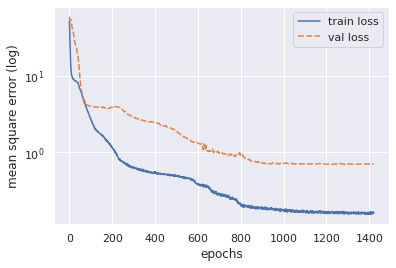

In [119]:
sns.lineplot(data=[history.history['loss'],history.history['val_loss']]).set(yscale='log',xlabel='epochs',ylabel='mean square error (log)')
plt.legend(labels=['train loss','val loss'])

In [112]:
result = np.round(network.predict(matrix_test)).astype(int).reshape(-1)

In [114]:
np.sum(result-h11_test.values == 0)/len(h11_test.values)

0.767175572519084